**Глебенков С.А. КЭ-404**


---


Разработайте программу, которая выполняет поиск частых наборов объектов в заданном наборе данных с помощью алгоритма Apriori (или одной из его модификаций). Список результирующих наборов должен содержать как наборы, так и значение поддержки для каждого набора. Параметрами программы являются набор, порог поддержки и способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).

Проведите эксперименты на наборе данных baskets.csv (сведения о покупках в супермаркете). В экспериментах варьируйте пороговое значение поддержки (например: 1%, 3%, 5%, 10%, 15%).

Выполните визуализацию результатов экспериментов в виде следующих диаграмм:

- сравнение быстродействия на фиксированном наборе данных при изменяемом пороге поддержки;

- количество частых наборов объектов различной длины на фиксированном наборе данных при изменяемом пороге поддержки.

Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  

- формулировка задания;

- гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами;

- рисунки с результатами визуализации;

- пояснения, раскрывающие смысл полученных результатов.

In [2]:
import pandas as pd
import chardet
import time
import matplotlib.pyplot as plt
from google.colab import drive
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [3]:
# Монтируем Google Диск
drive.mount('/content/drive')

# Путь к файлу на Google Диске
file_path = '/content/drive/MyDrive/collabFiles2/baskets.csv'

# Определяем кодировку
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())

# Читаем CSV с нужной кодировкой
df = pd.read_csv(file_path, encoding=result['encoding'])
df


Mounted at /content/drive


,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
0,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,низкокалорийный йогурт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7496,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Этот код реализует функцию find_frequent_itemsets_by_support, которая предназначена для нахождения частых наборов в транзакционных данных с использованием алгоритма Apriori.

В начале данных, представленных в виде таблицы (например, DataFrame), преобразуется в список списков. Каждый список представляет собой одну транзакцию, где элементы (товары или объекты) являются покупками, сделанными в этой транзакции. Это преобразование необходимо для того, чтобы подать данные в алгоритм, который работает с транзакциями в виде списков.

Затем из каждого списка транзакций удаляются значения NaN с помощью спискового включения. Если в каком-то элементе транзакции присутствует NaN, то он будет исключён. Этот шаг гарантирует, что алгоритм будет работать только с валидными данными, игнорируя пропущенные значения, которые могут вызвать ошибки при дальнейшем анализе.

После этого используется TransactionEncoder из библиотеки mlxtend, который преобразует список транзакций в разряженную матрицу. Эта матрица имеет вид таблицы, где строки соответствуют транзакциям, а столбцы — отдельным элементам (например, товарам). Если элемент присутствует в транзакции, то в соответствующей ячейке будет стоять 1, если нет — 0. Это преобразование необходимо для того, чтобы алгоритм Apriori мог эффективно анализировать наборы элементов в каждой транзакции.

Затем алгоритм Apriori применяется к этой разряженной матрице для поиска частых наборов. Важным параметром является min_support, который задаёт минимальный порог поддержки для того, чтобы набор был признан частым. Поддержка набора — это доля транзакций, в которых встречается этот набор элементов. Алгоритм находит все такие наборы, которые встречаются хотя бы в min_support процентов от всех транзакций.

In [5]:
def find_frequent_itemsets_by_support(data, min_support):
    transactions = data.values.tolist()

    # Удаление значений NaN
    transactions = [[item for item in transaction if not pd.isnull(item)] for transaction in transactions]

    # Преобразование в разряженную матрицу
    te = TransactionEncoder()
    te_transform = te.fit(transactions).transform(transactions)
    transactions_matrix = pd.DataFrame(te_transform, columns=te.columns_)

    # Поиск частых наборов с помощью алгоритма Apriori
    frequent_itemsets = apriori(transactions_matrix, min_support=min_support, use_colnames=True)
    frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

    return frequent_itemsets

In [6]:
min_support = 0.03
result = find_frequent_itemsets_by_support(df, min_support)
result.head(10)

,support,itemsets
14,0.238267,(минеральная вода)
12,0.188000,(макароны)
35,0.179733,(яйца)
8,0.170933,(картофель-фри)
33,0.163867,(шоколад)
6,0.132000,(зеленый чай)
15,0.129600,(молоко)
3,0.098267,(говяжий фарш)
4,0.095333,(замороженные овощи)
1,0.095067,(блинчики)


лексиграфическая сортировка

In [5]:
def find_frequent_itemsets_by_itemsets(data, min_support):
    # Преобразование данных в список списков для подачи в метод fit
    transactions = data.values.tolist()

    # Удаление значений NaN из транзакций
    transactions = [[item for item in transaction if not pd.isnull(item)] for transaction in transactions]

    # Преобразование в разряженную матрицу
    te = TransactionEncoder()
    te_transform = te.fit(transactions).transform(transactions)
    transactions_matrix = pd.DataFrame(te_transform, columns=te.columns_)

    # Поиск частых наборов с помощью алгоритма Apriori
    frequent_itemsets = apriori(transactions_matrix, min_support=min_support, use_colnames=True)
    frequent_itemsets['itemsets_sorted'] = frequent_itemsets['itemsets'].apply(lambda x: sorted(list(x)))
    frequent_itemsets = frequent_itemsets.sort_values(by='itemsets_sorted')

    return frequent_itemsets

In [6]:
min_support = 0.03
result = find_frequent_itemsets_by_itemsets(df, min_support)
result.head(10)

,support,itemsets,itemsets_sorted
0,0.033200,(авокадо),[авокадо]
1,0.095067,(блинчики),[блинчики]
36,0.033733,"(минеральная вода, блинчики)","[блинчики, минеральная вода]"
2,0.087200,(гамбургер),[гамбургер]
3,0.098267,(говяжий фарш),[говяжий фарш]
37,0.040267,"(макароны, говяжий фарш)","[говяжий фарш, макароны]"
38,0.040933,"(говяжий фарш, минеральная вода)","[говяжий фарш, минеральная вода]"
4,0.095333,(замороженные овощи),[замороженные овощи]
39,0.035733,"(замороженные овощи, минеральная вода)","[замороженные овощи, минеральная вода]"
5,0.063200,(замороженный смузи),[замороженный смузи]


In [ ]:
# Минимальное число элементов в наборе - 2
result_with_2_items = result[result['itemsets'].apply(lambda x: len(x)) == 2]
result_with_2_items

,support,itemsets
185,0.061200,"(макароны, минеральная вода)"
213,0.052667,"(минеральная вода, шоколад)"
215,0.050933,"(минеральная вода, яйца)"
201,0.048000,"(минеральная вода, молоко)"
105,0.040933,"(минеральная вода, говяжий фарш)"
...,...,...
96,0.010267,"(рис, гамбургер)"
237,0.010133,"(шоколад, суп)"
121,0.010133,"(низкокалорийный йогурт, замороженные овощи)"
154,0.010000,"(картофель-фри, креветки)"


In [ ]:
# Минимальное число элементов в наборе - 3
result_with_3_items = result[result['itemsets'].apply(lambda x: len(x)) == 3]
result_with_3_items

,support,itemsets
247,0.017200,"(макароны, минеральная вода, говяжий фарш)"
256,0.016400,"(макароны, минеральная вода, шоколад)"
254,0.016133,"(макароны, минеральная вода, молоко)"
257,0.015200,"(макароны, минеральная вода, яйца)"
260,0.014000,"(минеральная вода, шоколад, молоко)"
262,0.013467,"(минеральная вода, яйца, шоколад)"
261,0.013067,"(минеральная вода, яйца, молоко)"
251,0.012267,"(макароны, минеральная вода, замороженные овощи)"
246,0.011733,"(макароны, минеральная вода, блинчики)"
258,0.011200,"(макароны, молоко, шоколад)"


Функция plot_execution_time(data, min_support_values) строит график, отображающий, сколько времени занимает выполнение алгоритма поиска частых наборов при разных значениях порога поддержки. Сначала она вызывает функцию measure_execution_time для каждого значения из min_support_values, чтобы узнать, сколько секунд занимает выполнение поиска. Результаты сохраняются, после чего с помощью библиотеки matplotlib строится линейный график: по оси X – значения поддержки, по оси Y – соответствующее время выполнения. Это позволяет визуально оценить, как чувствителен алгоритм к уменьшению или увеличению поддержки.

Функция measure_execution_time(data, min_support) отвечает за непосредственное измерение времени. Она запускает таймер перед вызовом основной функции поиска (find_frequent_itemsets_by_support) и останавливает таймер сразу после её завершения. Разница между временем окончания и начала – это и есть длительность выполнения. Эта информация возвращается в виде одного числа (в секундах).

Следующая функция, plot_frequent_itemset_length(data, min_support_values), анализирует, как изменяется количество частых наборов разной длины при разных порогах поддержки. В начале создаётся структура для хранения данных: она будет запоминать, сколько одноэлементных, двухэлементных и т.д. наборов найдено при каждом пороге. Далее происходит перебор значений min_support, и на каждом шаге вызывается функция find_frequent_itemsets_by_support, которая находит частые наборы. Затем с помощью метода .apply() считается длина каждого набора, и производится подсчёт количества наборов каждой длины.

In [25]:
# Диаграмма сравнения времени выполнения
def plot_execution_time(data, min_support_values):
    execution_times = [measure_execution_time(data, min_support) for min_support in min_support_values]

    plt.figure(figsize=(10, 6))
    plt.plot(min_support_values, execution_times, marker='o', linestyle='-')
    plt.title('Сравнение времени выполнения при изменении порога поддержки')
    plt.xlabel('Порог поддержки')
    plt.ylabel('Время выполнения (секунды)')
    plt.grid(True)
    plt.show()

# Диаграмма количества частых наборов объектов различной длины
def plot_frequent_itemset_length(data, min_support_values):
    number_of_items_by_length = {i: [] for i in range(1, len(min_support_values) - 1)}
    supports = []

    for min_support in min_support_values:
        frequent_itemsets = find_frequent_itemsets_by_support(data, min_support)

        # Подсчет количества наборов разной длины
        counts = frequent_itemsets['itemsets'].apply(lambda x: len(x)).value_counts().sort_index()

        # Сохраняем результаты
        for length in number_of_items_by_length.keys():
            number_of_items_by_length[length].append(counts.get(length, 0))
        supports.append(min_support)

    # Создаем диаграмму
    plt.figure(figsize=(10, 6))

    # Для каждой длины набора
    for length, counts in number_of_items_by_length.items():
        plt.plot(supports, counts, label=f'Кол-во элементов в наборе: {length}')

    plt.xlabel('Поддержка')
    plt.ylabel('Число наборов')
    plt.title('Число частых наборов разных длин при изменяемом пороге поддержки')
    plt.legend()
    plt.grid(True)
    plt.show()

def measure_execution_time(data, min_support):
    start_time = time.time()
    find_frequent_itemsets_by_support(data, min_support)
    end_time = time.time()
    return end_time - start_time


min_support_values = [0.01, 0.03, 0.05, 0.10, 0.15]

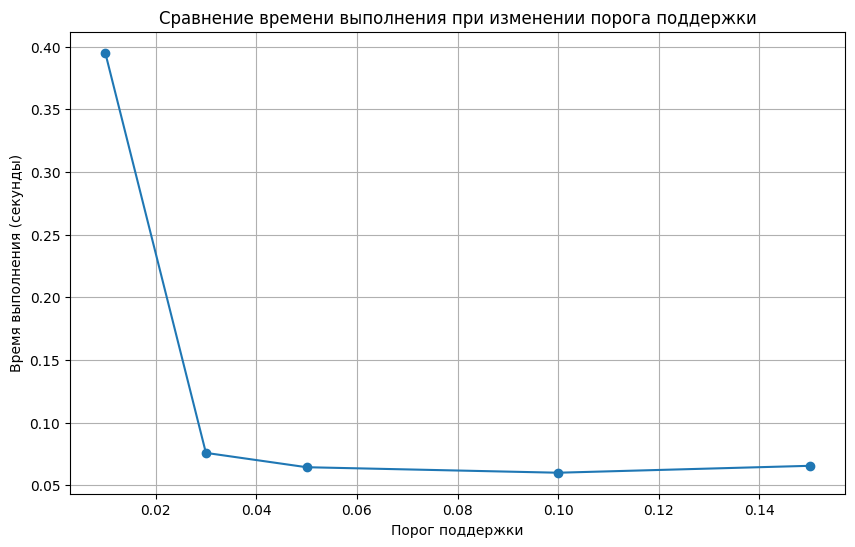

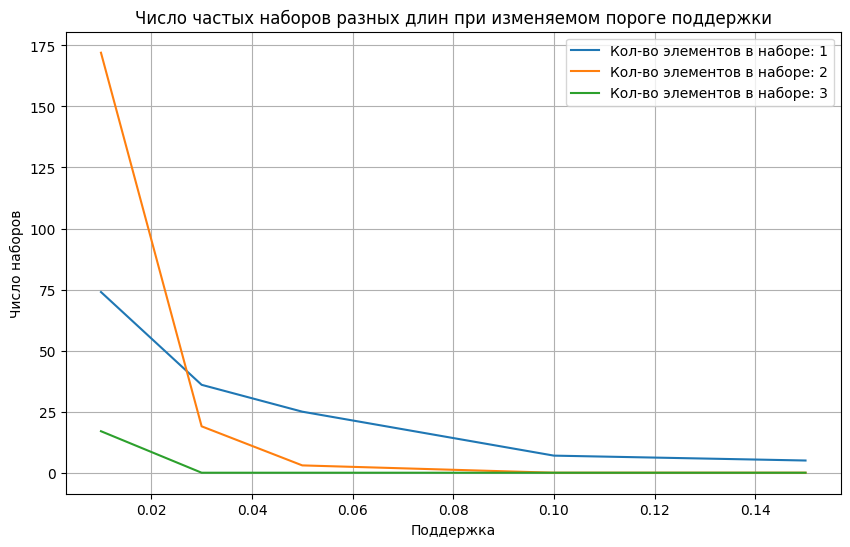

In [26]:
plot_execution_time(df, min_support_values)
plot_frequent_itemset_length(df, min_support_values)